### This document contains all the scripts that we used to analyse the Booter Ecosystem. Part of the analyses were included in the (under reviewing process) academic article **"Quiet Dogs Can Bite: What Booters We Should Go After? And Which Are Our Mitigation Options?"** 

The great advantage of this document format is that is written using [Jupyter Notebook](http://jupyter.org), which allows anyone to easily understand, reproduce, and extend our analysis and results.

### Please do not hesitate to contact us if you find any mistake [(j.j.santanna@utwente.nl).](mailto:j.j.santanna@utwente.nl)

# 1. General Required Libraries 

In [1]:
from random import choice, random, randint 
import time 

import pandas as pd #more info at http://pandas.pydata.org/
import numpy as np #more info at http://www.numpy.org/
import matplotlib.pyplot as plt #some examples for you at http://matplotlib.org/gallery.html 
from matplotlib import gridspec #more info at http://matplotlib.org/api/gridspec_api.h}tml
import matplotlib.dates as dt
from matplotlib.patches import Rectangle
from matplotlib import ticker

from matplotlib_venn import *
%matplotlib inline 

plt.style.use('ggplot') #For improving the visualization style (options: grayscale, bmh, dark_background, ggplot, and fivethirtyeight)

import re

import warnings
warnings.filterwarnings('ignore') #To avoid showing annoying warns

from IPython.display import display

output_figures = 'figs/'
# output_figures = '../../figs/' #if generating already in the paper folder

# 2. Reading the (input) Booter list (from a file)

In [130]:
df = pd.read_csv('enrichments/20180215_groundtruth.csv')
df = df[df['booter?']=='Y']['url'].to_frame()
df.rename(columns={'url':'booter'},inplace=True)

In [3]:
len(df)

519

# 3. Collecting and Analysing the status of online pages

In [4]:
%run 'functions/runfunction2csv.ipynb'

run_function2csv(function, pandasseries, csv_name.csv, log=True):
   writes into csv_name.csv: 'pandaseries_element; function_output; year_month_day'
   return None


## 3.A. Checking the status of (booter) URL(s)

Enabling the function:

In [5]:
%run 'functions/url_status.ipynb'

url_status('url')
   return 'status;status_code'

*ATTENTION: the status 'online-blazingfast' and 'online-cloudflare_captch' MUST be MANUALLY checked!!


Example:

In [6]:
url_status('powerstresser.com')

'online;200'

Running url_status() for ALL booters and saving into a csv (for future analysis):

In [7]:
runfunction2csv(url_status, df['booter'], 'url_status.csv', True)

The file already exists!


## Filtering the ONLINE booters

*After manually checking the 'online-blazingfast' and 'online-cloudflare_captcha'

In [8]:
df_url_status = pd.read_csv('enrichments/url_status.csv',\
                        names = ['booter','status','status_code','measurement_date'],\
                        delimiter=";")

df_onlinebooters = df_url_status[df_url_status['status']=='online']['booter'].reset_index()
del df_onlinebooters['index']

## Alexa rank (ONLINE booters)

Enabling the function:

In [9]:
%run 'functions/scrape_alexarank.ipynb'

scrape_alexarank(domain, delay=3):
   return 'current_rank; 3monthago_rank'


Example:

In [10]:
scrape_alexarank('nu.nl',3)

'2736.0;2918.0'

Running scraping_alexarank() for all ONLINE booters:

In [11]:
runfunction2csv(scrape_alexarank, df_onlinebooters['booter'], 'domain_alexarank.csv', True)

The file already exists!


Reading the output of scrape_alexarank() for all the ONLINE booters:

In [12]:
df_alexa = pd.read_csv('enrichments/domain_alexarank.csv',\
                        names = ['booter','rank_current','rank_3months_ago','measurement_date'],\
                        delimiter=";")

len(df_alexa)

78

Filtering ONLY the booters that have alexa rank:

In [13]:
booters_with_alexarank = df_alexa[~df_alexa['rank_current'].isnull()].sort_values(by='rank_current',ascending=False).reset_index(drop=True)

ranking = booters_with_alexarank.iloc[::-1].index
ranking +=1

len(booters_with_alexarank)

55

Visualizing the findings:

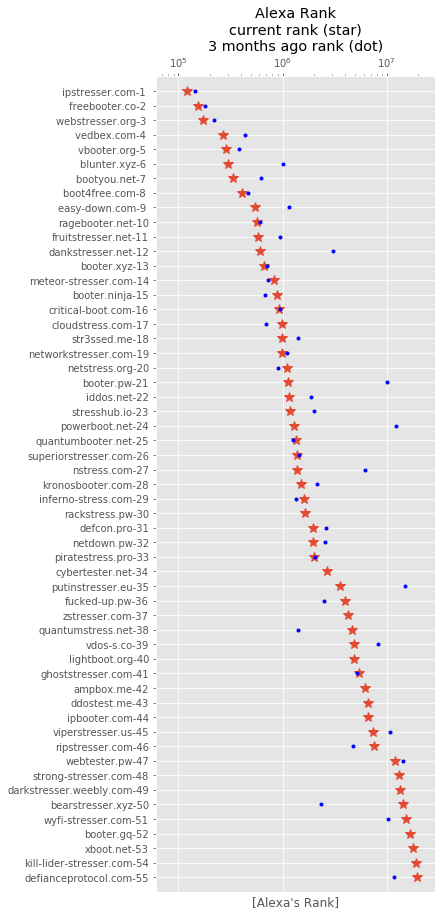

In [14]:
fig = plt.figure(figsize=(5, 15))

ax = plt.subplot2grid((1,1), (0,0))
ax.set_title('Alexa Rank\ncurrent rank (star)\n3 months ago rank (dot)', y=1.025)

ax.xaxis.set_ticks_position('top')
booters_with_alexarank.reset_index().plot(ax=ax,x='rank_current',y='index',style='*',legend=False,logx=True,markersize=10)
booters_with_alexarank.reset_index().plot(ax=ax,x='rank_3months_ago',y='index',style='.',legend=False,logx=True,color='b')
ax.set_xlim(min(booters_with_alexarank['rank_current'])*0.5,max(booters_with_alexarank['rank_current'])*1.5)
plt.yticks(booters_with_alexarank.index, booters_with_alexarank['booter'].str.cat(ranking.format(), sep='-'))
ax.set_ylim(-1,len(booters_with_alexarank.index))

plt.xlabel('[Alexa\'s Rank]', fontsize=12)


fig.show()
fig.savefig(output_figures+'alexarank_scatter.eps', bbox_inches='tight',format='eps', dpi=1200)

## WHOIS Information (for ONLINE Booters with Alexa Rank)

In [15]:
%run 'functions/domain_whois_info.ipynb'

domain_whois_info(domain):
   return 'registration_date, expiration_date, update_date, nameservers, emails, registrar'


In [16]:
domain_whois_info('jairsantanna.com')

'2015-04-28 19:13:22;2019-04-28 19:13:22;2017-01-30 08:24:02;FAY.NS.CLOUDFLARE.COM,LYNN.NS.CLOUDFLARE.COM;abuse@godaddy.com;GoDaddy.com, LLC'

In [19]:
runfunction2csv(domain_whois_info, booters_with_alexarank['booter'], 'domain_whois_info.csv', True)

The file already exists!


In [20]:
%run 'functions/datetime_converter.ipynb'
%run 'functions/tolowercase.ipynb'

df_whois_info = pd.read_csv('enrichments/domain_whois_info.csv',\
                        names = ['booter','registration_date','expiration_date','update_date','nameservers','email','registrar','measurement_date'],\
                        delimiter=";",\
                         converters = {'registration_date' : datetime_converter,
                                'expiration_date' : datetime_converter,
                                'update_date':datetime_converter,
#                                       'registrar':tolowercase,
#                                       'nameservers':tolowercase 
                                      })

## 4.F. Analysing the Name Servers (pie chart)

In [21]:
nameservers = df_whois_info['nameservers'].\
                                        dropna().\
                                        str.lower().\
                                        str.rsplit('.', 1).\
                                        str[0].\
                                        str.split('.').\
                                        str[-1].\
                                        value_counts()

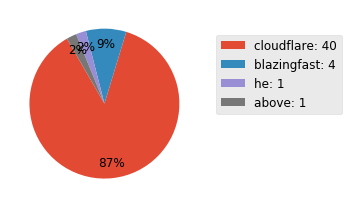

In [22]:
fig = plt.figure(figsize=(3, 3))
# fig.suptitle('Name Servers Frequency', fontsize=14)
    
ax1 = plt.subplot2grid((1,1), (0,0))

def my_autopct(pct):
    return ('%.0f' % pct)+"%" if pct > 2 else ''

nameservers.plot(ax=ax1,kind='pie', labels=None, autopct=my_autopct,startangle=120,pctdistance=0.8, labeldistance=1.05,fontsize=12)
ax1.set_ylabel("")

# For Pie Chart Better Legend boxb
labels = ['{0}: {1}'.format(i,j) for i,j in zip(nameservers.index, nameservers.values)]
legend_show_top=8
ax1.legend(ax1.patches[0:legend_show_top], 
           labels[0:legend_show_top], 
           bbox_to_anchor=(1.8, 0.9),
           fontsize=12).set_zorder(0)

fig.tight_layout()
fig.show()
fig.savefig(output_figures+'nameservers_pie.eps', bbox_inches='tight',format='eps', dpi=1200)

## 4.G. Domain Registrars

In [23]:
registrar = df_whois_info['registrar'].dropna().str.lower().str.split(',').str[0].str.split().str.get(0).value_counts()

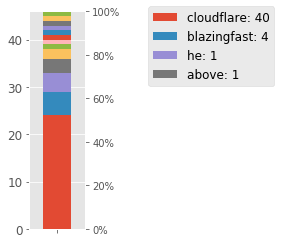

In [24]:
fig = plt.figure(figsize=(1, 4))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax2 = plt.subplot2grid((1,1), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

registrar.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12).set_zorder(1)
ax2.set_xlabel("")
ax2.set_ylim(0,len(df_whois_info['registrar'].dropna()))

legend_show_top=12
ax2.legend(ax2.patches[0:legend_show_top], 
           labels[0:legend_show_top], 
           bbox_to_anchor=(4.5, 1.05),
           fontsize=12)
# .set_zorder(1)
plt.setp( ax2.get_xticklabels(), visible=False)


fig.show()
fig.savefig(output_figures+'registrars_stacked.eps', bbox_inches='tight',format='eps', dpi=1200)

## 4.J. Analysing Domain Creation & Expiration (scatter plot)

In [25]:
booters_with_creation_expiration = df_whois_info[df_whois_info['registration_date'].notnull()][df_whois_info['expiration_date'].notnull()].sort_values('registration_date',ascending=False).reset_index(drop=True)

ranking = booters_with_creation_expiration.iloc[::-1].index
ranking +=1

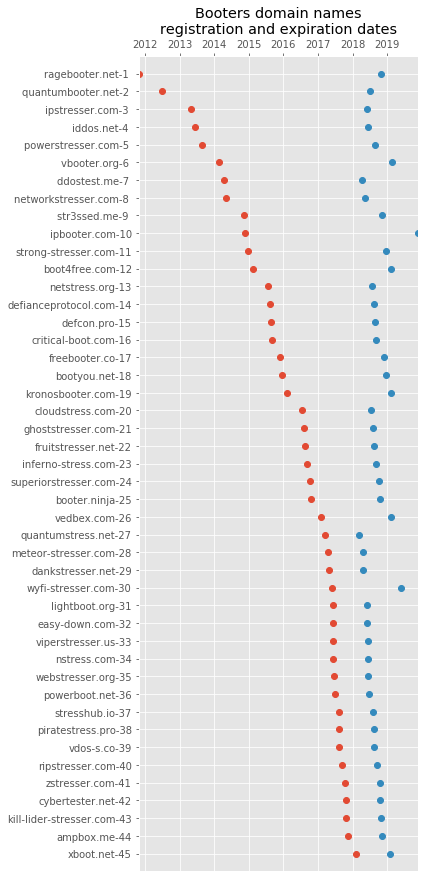

In [26]:
fig = plt.figure(figsize=(5, 15))

ax = plt.subplot2grid((1,1), (0,0))
ax.set_title('Booters domain names\nregistration and expiration dates', y=1.02)
ax.xaxis.set_ticks_position('top')

plt.plot_date(x=booters_with_creation_expiration['registration_date'],\
              y=booters_with_creation_expiration.index)

plt.plot_date(x=booters_with_creation_expiration['expiration_date'],\
              y=booters_with_creation_expiration.index)

plt.yticks(booters_with_creation_expiration.index, booters_with_creation_expiration['booter'].str.cat(ranking.format(), sep='-'))

ax.set_ylim(-1,len(booters_with_creation_expiration.index))
ax.set_xlim(min(booters_with_creation_expiration['registration_date']),max(booters_with_creation_expiration['expiration_date']))


fig.show()
fig.savefig(output_figures+'domain_creation_expiration_scatter.eps', bbox_inches='tight',format='eps', dpi=1200)

# 5. Analysing the Top Ranked Booters

## 5.A. Defining top ranked Booters (Alexa rank < 3M)
*According to [Verigsign](https://investor.verisign.com/releasedetail.cfm?releaseid=980215) there are 326 Million domain names registered. Therefore, Alexa rank lower than 3 Million represents the top 1% most accessed Websites in the entire Internet.  

In [28]:
df_popular_booters=booters_with_alexarank[booters_with_alexarank['rank_current']<=3000000]
df_popular_booters

,booter,rank_current,rank_3months_ago,measurement_date
21,cybertester.net,2652001.0,NaN,20180223
22,piratestress.pro,2023421.0,2034681.0,20180223
23,netdown.pw,1978066.0,2539215.0,20180223
24,defcon.pro,1954877.0,2639752.0,20180223
25,rackstress.pw,1633780.0,NaN,20180223
26,inferno-stress.com,1596203.0,1350536.0,20180223
27,kronosbooter.com,1508591.0,2122807.0,20180223
28,nstress.com,1369637.0,6209745.0,20180223
29,superiorstresser.com,1367825.0,1445427.0,20180223
30,quantumbooter.net,1341304.0,1250544.0,20180223


## 5.B. Manually identifying and removing the top ranked Booters OUTILIERS
which booter (index number) should be removed?

In [29]:
# df_popular_booters.drop(df_popular_booters.index[[0,1,3]], inplace=True) 

## 5.D. Analysing top ranked Booters (scatter plot)

In [30]:
df_popular_booters.sort_values(['rank_current'], ascending=False, inplace=True)
df_popular_booters.reset_index(inplace=True,drop=True)

popular_booters_extended= pd.merge(df_popular_booters,
                                      booters_with_creation_expiration,
                                      how = 'left',
                                      left_on = 'booter',
                                      right_on = 'booter')

ranking = popular_booters_extended.iloc[::-1].index
ranking +=1

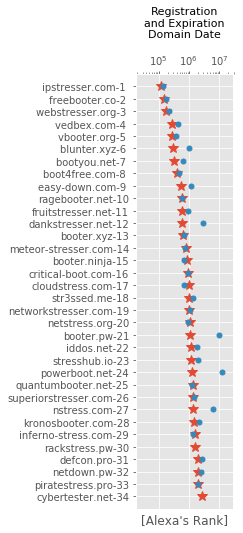

In [32]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((1,4), (0,0))
ax1.set_title('Registration\nand Expiration\nDomain Date', y=1.07,size=11)
ax1.xaxis.set_ticks_position('top')

popular_booters_extended.reset_index().plot(ax=ax1,x='rank_current',y='index',style='*',legend=False,logx=True,markersize=10)
popular_booters_extended.reset_index().plot(ax=ax1,x='rank_3months_ago',y='index',style='.',legend=False,logx=True,markersize=10)

plt.yticks(popular_booters_extended.index, popular_booters_extended['booter'].str.cat(ranking.format(), sep='-'))

ax1.set_ylim(-1,len(popular_booters_extended.index))
ax1.set_xlim(min(booters_with_alexarank['rank_current'])*0.15,max(booters_with_alexarank['rank_current'])*1.5)

plt.xlabel('[Alexa\'s Rank]', fontsize=12)

fig.show()
fig.savefig(output_figures+'topranked_alexa_rank_scatter.eps', bbox_inches='tight',format='eps', dpi=1200)

## 5.E. Analysing top ranked Booters Domain Registration and Expiration Date (scatter plot)

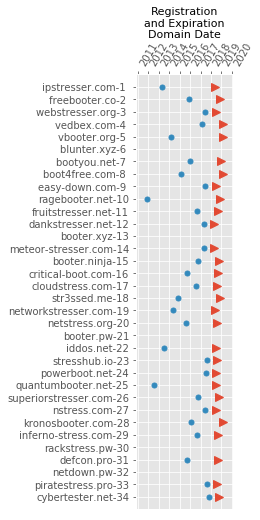

In [33]:
fig = plt.figure(figsize=(8, 8))
ax4 = plt.subplot2grid((1,4), (0,3))
ax4.set_title('Registration\nand Expiration\nDomain Date', y=1.07,size=11)
ax4.xaxis.set_ticks_position('top')

ax4.plot_date(x=popular_booters_extended['expiration_date'],\
               y=popular_booters_extended.index,marker='>',markersize=8)

ax4.plot_date(x=popular_booters_extended['registration_date'],\
              y=popular_booters_extended.index,markersize=5)


plt.yticks(popular_booters_extended.index, popular_booters_extended['booter'].str.cat(ranking.format(), sep='-'))

ax4.set_ylim(-1,len(popular_booters_extended.index))
ax4.set_xlim(min(popular_booters_extended['registration_date'])-pd.DateOffset(years=1),max(popular_booters_extended['expiration_date'])+pd.DateOffset(years=1))
plt.setp(ax4.get_xticklabels(), rotation=60,ha='left')

ax4.yaxis.set_ticks(popular_booters_extended.index)


fig.show()
fig.savefig(output_figures+'topranked_domain_creation_expiration_scatter.eps', bbox_inches='tight',format='eps', dpi=1200)

## 5.F. Analysing Top Ranked Booter Prices (box plot)
[data collected manually]

In [ ]:
df_prices = pd.read_csv('enrichments/prices.csv',sep=';').reset_index(drop=True)
df_prices = df_prices[df_prices.columns[::-1]]

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax2 = plt.subplot2grid((1,4), (0,1))
ax2.xaxis.set_ticks_position('top')

df_prices.boxplot(vert=False,ax=ax2,
                  flierprops={'marker': '.'},
                  whiskerprops={'linestyle':'-'},
                  medianprops={'linewidth':2})

ax2.set_xlim(-10,500)
plt.xlabel('[US$]', fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=60,ha='center')

plt.yticks(popular_booters_extended.index+1, df_prices.columns)
ax2.set_ylim(0,len(df_prices.columns)+1)

plt.show()
fig.savefig(output_figures+'topranked_prices_boxplot.eps', bbox_inches='tight',format='eps', dpi=1200)

## 5.G. Analysing Top Ranked Booter Attack Power (bar plot)

In [41]:
df_attack_power = pd.read_csv('enrichments/attack_power.csv',sep=';',names=['booter', 'max_attack_power'])
# df_attack_power.columns = ['booter', 'max_attack_power']

popular_booters_extended= pd.merge(popular_booters_extended,
                                      df_attack_power,
                                      how = 'left',
                                      left_on = 'booter',
                                      right_on = 'booter')

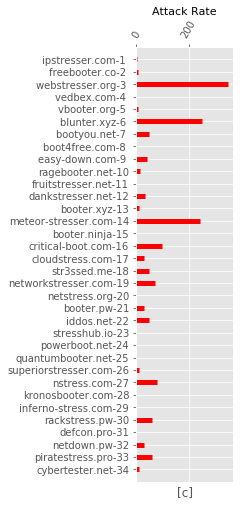

In [44]:
fig = plt.figure(figsize=(8, 8))
ax3 = plt.subplot2grid((1,4), (0,2))
ax3.set_title('Attack Rate', y=1.06,size=11)

ax3.xaxis.set_ticks_position('top')

ax3.hlines(popular_booters_extended.index, 0, popular_booters_extended['max_attack_power'],linewidths=5,color='r')

ax3.set_xlim(0,max(popular_booters_extended['max_attack_power'].dropna())+20)
plt.xlabel('[c]', fontsize=12)
plt.setp(ax3.get_xticklabels(), rotation=60,ha='center')

plt.yticks(popular_booters_extended.index, popular_booters_extended['booter'].str.cat(ranking.format(), sep='-'))
ax3.set_ylim(-1,len(popular_booters_extended['booter']))


plt.show()
fig.savefig(output_figures+'topranked_maxattack_bar.eps', bbox_inches='tight',format='eps', dpi=1200)

# 5.H. Combining Top Booter (1) Web Rank, (2) Price Range, (3) Max Attack Range, and (4) Creation & Expiration Domain Dates 

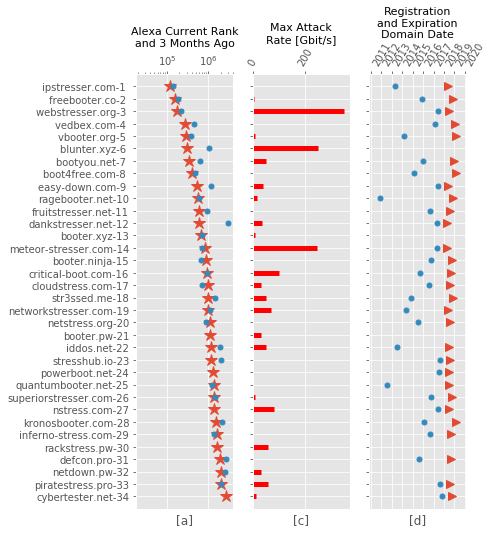

In [47]:
import matplotlib.dates as dates

fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot2grid((1,4), (0,0))
ax1.set_title('Alexa Current Rank\nand 3 Months Ago', y=1.05,size=11)
ax1.xaxis.set_ticks_position('top')

popular_booters_extended.reset_index().plot(ax=ax1,x='rank_current',y='index',style='*',legend=False,logx=True,markersize=12)
popular_booters_extended.reset_index().plot(ax=ax1,x='rank_3months_ago',y='index',style='.',legend=False,logx=True,markersize=10)

plt.yticks(popular_booters_extended.index, popular_booters_extended['booter'].str.cat(ranking.format(), sep='-'))

ax1.set_ylim(-1,len(popular_booters_extended.index))
ax1.set_xlim(min(popular_booters_extended['rank_current'])*0.15,max(popular_booters_extended['rank_current'])*1.5)



plt.xlabel('[a]', fontsize=12)

######################################
# ATTACK RATE
ax2 = plt.subplot2grid((1,4), (0,1))
ax2.set_title('Max Attack\nRate [Gbit/s]', y=1.06,size=11)

ax2.xaxis.set_ticks_position('top')

ax2.hlines(popular_booters_extended.index, 0, popular_booters_extended['max_attack_power'],linewidths=5,color='r')

ax2.set_xlim(0,max(popular_booters_extended['max_attack_power'].dropna())+20)
plt.xlabel('[c]', fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=60,ha='center')

plt.yticks(popular_booters_extended.index, popular_booters_extended['booter'])
ax2.set_ylim(-1,len(popular_booters_extended['booter']))
ax2.set_yticklabels([])

# ######################################
# #PRICE RANGE
# ax3 = plt.subplot2grid((1,4), (0,3))
# ax3.set_title('Price\nRange [US$]', y=1.06,size=11)
# ax3.xaxis.set_ticks_position('top')
# df_prices.boxplot(vert=False,ax=ax3, 
# #                   patch_artist=True,
#                  flierprops={'marker': '.'},
#                  whiskerprops={'linestyle':'-'},
#                  medianprops={'linewidth':2})

# ax3.set_xlim(-10,300)
# plt.xlabel('[b]', fontsize=12)
# plt.setp(ax3.get_xticklabels(), rotation=60,ha='center')

# plt.yticks(popular_booters_extended.index+1, df_prices.columns)
# ax3.set_ylim(0,len(df_prices.columns)+1)
# ax3.set_yticklabels([])

######################################
#DOMAIN REGISTRATION
ax4 = plt.subplot2grid((1,4), (0,2))
ax4.set_title('Registration\nand Expiration\nDomain Date', y=1.07,size=11)
ax4.xaxis.set_ticks_position('top')

ax4.plot_date(x=popular_booters_extended['expiration_date'],\
               y=popular_booters_extended.index,marker='>',markersize=8)

ax4.plot_date(x=popular_booters_extended['registration_date'],\
              y=popular_booters_extended.index,markersize=5)


plt.yticks(popular_booters_extended.index, popular_booters_extended['booter'])

ax4.set_ylim(-1,len(popular_booters_extended.index))
ax4.set_xlim(min(popular_booters_extended['registration_date'])-pd.DateOffset(years=1),max(popular_booters_extended['expiration_date'])+pd.DateOffset(years=1))
plt.setp(ax4.get_xticklabels(), rotation=60,ha='left')

ax4.yaxis.set_ticks(popular_booters_extended.index)
ax4.set_yticklabels([])
plt.xlabel('[d]', fontsize=12)

######################################
# ax1.annotate('', xytext=(-0.9, 0.68), xy=(-0.9, 0.12), xycoords='axes fraction', 
#             arrowprops=dict(arrowstyle="<->", color='gray',connectionstyle='bar,fraction=0.2'))

fig.show()
fig.savefig(output_figures+'topranked_general.eps', bbox_inches='tight',format='eps', dpi=1200)

# 6. Analysing Top Level Domain (TLDs) of ALL booters

In [48]:
df['tld']=df['booter'].str.split('.').str[-1]
freq_tld = df['tld'].value_counts()

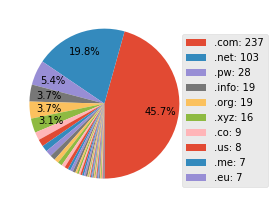

In [49]:
fig = plt.figure(figsize=(3, 3))
fig.suptitle('Booter Domain Names in TLDs', fontsize=14)
    
ax1 = plt.subplot2grid((1,1), (0,0))

def my_autopct(pct):
    return ('%.1f' % pct)+"%" if pct > 3 else ''

freq_tld.plot(ax=ax1,kind='pie', labels=None, autopct=my_autopct,startangle=270,pctdistance=0.75, labeldistance=1.05)
ax1.set_ylabel("")


# Legend boxb
labels = ['.{0}: {1}'.format(i,j) for i,j in zip(freq_tld.index, freq_tld.values)]
legend_show_top=10
ax1.legend(ax1.patches[0:legend_show_top], 
           labels[0:legend_show_top], 
           bbox_to_anchor=(1.4, 0.9),
           fontsize=10)

fig.tight_layout()
fig.show()
fig.suptitle('')
fig.savefig(output_figures+'tlds_pie.eps', bbox_inches='tight',format='eps', dpi=1200)

In [50]:
freq_tld['nl']

6

# 7. Analysing Booter Domain Name Composition (pie chart)

In [51]:
stress_dn=df['booter'][df['booter'].str.contains('stresser')]
boot_dn=df['booter'][df['booter'].str.contains('booter')]
ddos_dn=df['booter'][df['booter'].str.contains('ddos')]
concat_main_dn=pd.concat([stress_dn, boot_dn, ddos_dn])

other_dn=df['booter'][df['booter'].isin(concat_main_dn)==False]

domain_name_regex = pd.Series([len(stress_dn),
                               len(boot_dn),
                               len(ddos_dn),
                               len(other_dn)],\
                              index=['stress','boot','ddos','others'])

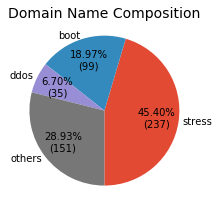

In [52]:
fig = plt.figure(figsize=(3, 3))
fig.suptitle('Domain Name Composition', fontsize=14)

ax1 = plt.subplot2grid((1,1), (0,0))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

domain_name_regex.plot(ax=ax1,
                       kind='pie', 
                       autopct=make_autopct(domain_name_regex.values),
                       startangle=270,
                       pctdistance=0.7,
                      labeldistance=1.05)
ax1.set_ylabel("")

fig.tight_layout()
fig.show()

fig.savefig(output_figures+'wildcards_pie.eps', bbox_inches='tight',format='eps', dpi=1200)

# 8. Combining TLD Analysis and Domain Name Composition (stacked bar)

In [53]:
df['wildcards2']=np.nan

df['wildcards2'][df['wildcards2'].isnull() & df['booter'].str.contains('stresser')]="stresser"
df['wildcards2'][df['wildcards2'].isnull() & df['booter'].str.contains('booter')]="booter"
df['wildcards2'][df['wildcards2'].isnull() & df['booter'].str.contains('ddos')]="ddos"
df['wildcards2'][df['wildcards2'].isnull()]="others"

order = ['stresser', 'booter', 'ddos', 'others']

wildcards2_tlds = df[['tld','wildcards2']].pivot_table(index='wildcards2',
                                                       columns='tld', 
                                                       aggfunc=len)

In [ ]:
fig = plt.figure(figsize=(5, 4))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax1 = plt.subplot2grid((1,1), (0,0))
# wildcards1_tlds.plot(kind='bar',ax=ax1, legend=False, stacked=True, title="",width = .3)
wildcards2_tlds.ix[order].plot(kind='bar',ax=ax1, stacked=True, title="",width = .8)

ax1.set_ylim(0,210)

ax1.set_xlabel("")
ax1.set_ylabel("# domain names")
ax1.xaxis.set_tick_params(labelsize=12)

ax1.set_xticklabels(['stresser\n'+str(len(df['wildcards2'][df['wildcards2']=='stresser']))+'\n'+str('({:.2f}%)'.format(len(df['wildcards2'][df['wildcards2']=='stresser'])*100/len(df))),
                     'booter\n'+str(len(df['wildcards2'][df['wildcards2']=='booter']))+'\n'+str('({:.2f}%)'.format(len(df['wildcards2'][df['wildcards2']=='booter'])*100/len(df))),
                     'ddos\n'+str(len(df['wildcards2'][df['wildcards2']=='ddos']))+'\n'+str('({:.2f}%)'.format(len(df['wildcards2'][df['wildcards2']=='ddos'])*100/len(df))),
                     'others\n'+str(len(df['wildcards2'][df['wildcards2']=='others'])-1)+'\n'+str('({:.2f}%)'.format((len(df['wildcards2'][df['wildcards2']=='others'])-1)*100/len(df)))],
                    rotation=0)

ax1.legend(['com', 'net'])

# Semi-automatic ANNOTATION 
ax1.text(0, 60,str(int(wildcards2_tlds.ix['stresser', 'com'])),ha="center", va="center",size=12)
ax1.text(0, 152,str(int(wildcards2_tlds.ix['stresser', 'net'])),ha="center", va="center",size=12)
ax1.text(1, 23,str(int(wildcards2_tlds.ix['booter', 'com'])),ha="center", va="center",size=12)
ax1.text(1, 67,str(int(wildcards2_tlds.ix['booter', 'net'])),ha="center", va="center",size=12)
ax1.text(2, 10,str(int(wildcards2_tlds.ix['ddos', 'com'])),ha="center", va="center",size=12)
ax1.text(3, 25,str(int(wildcards2_tlds.ix['others', 'com'])),ha="center", va="center",size=12)
ax1.text(3, 75,str(int(wildcards2_tlds.ix['others', 'net'])),ha="center", va="center",size=12)

fig.show()
fig.savefig(output_figures+'tlds_wildcards_stacked.eps', bbox_inches='tight',format='eps', dpi=1200)

# 9. Collecting IP addresses  of ONLINE booters

In [55]:
%run 'functions/domain2ip.ipynb'

domain2ip(domain):
   return 'IP address'


In [56]:
domain2ip('jairsantanna.com')

'104.28.3.97'

In [57]:
runfunction2csv(domain2ip, df_onlinebooters['booter'], 'domain_ip.csv', True)

asylumstresser.com;158.69.225.39;20180223
boot4free.com;104.27.183.246;20180223
booter.ninja;104.27.54.31;20180223
booter.xyz;104.27.147.179;20180223
bootr.org;69.162.80.56;20180223
connectionstresser.com;104.28.3.118;20180223
darkstresser.weebly.com;199.34.228.54;20180223
ddos.tools;104.31.114.120;20180223
downthem.org;104.28.29.34;20180223
freestresser.net;95.211.219.66;20180223
ghoststresser.com;104.27.49.68;20180223
hyperstresser.com;192.185.4.59;20180223
iddos.net;104.18.57.17;20180223
ipstresser.com;141.101.121.252;20180223
networkstresser.com;104.31.15.174;20180223
nuke.pe.hu;31.170.164.161;20180223
nullednetwork.com;208.94.117.220;20180223
opaquebooter.weebly.com;199.34.228.54;20180223
quantumbooter.net;104.31.6.158;20180223
quantumstresser.com;207.174.213.34;20180223
quantumstresser.net;104.31.11.160;20180223
signalstresser.com;104.24.106.171;20180223
str3ssed.me;104.18.43.35;20180223
strong-stresser.com;104.28.20.37;20180223
vbooter.org;104.28.12.7;20180223
xboot.net;103.224.

In [58]:
df_ips = pd.read_csv('enrichments/domain_ip.csv', names = ['booter','ip','measurement_date'], delimiter=";")

# 10. Collecting and Analysing Autonomous Systems (ASes)

In [59]:
%run 'functions/teamcymru_ip2asn_bulk.ipynb'

teamcymru_ip2asn_bulk(pandaseries_ips, outputfile):
   writes teamcymru bulk-request output  ('asn', 'ip', 'bgp_prefix', 'country','registry','info_date','as_name')  into outputfile 
   return None


In [60]:
teamcymru_ip2asn_bulk(df_ips['ip'],'domain_asn_teamcymru.txt') 

In [61]:
df_ips_iptoasn = pd.read_csv('enrichments/domain_asn_teamcymru.txt',\
                             skiprows=1,\
                             delimiter="\s+\|\s",\
                             names = ['asn', 'ip', 'bgp_prefix', 'country','registry','info_date','as_name'])

## 10.F. Combining IP addresses and ASes for the Booters List 

In [62]:
df_ips_extended= pd.merge(df_ips,df_ips_iptoasn,
                          how = 'left',
                          left_on = 'ip',
                          right_on = 'ip')

## 10.G. Analysing ASes 

In [63]:
asn_all=df_ips_extended['as_name']\
                            .dropna()\
                            .str.split(' - ')\
                            .str[0]\
                            .str.split(',')\
                            .str[0]\
                            .str.strip()\
                            .str.split('-')\
                            .str[0]\
                            .str.lower()
asn=asn_all.value_counts()

# Correction for godaddy (which with our processing became 'as')
asn.index=asn.index.str.replace('as','godaddy',n=1)

#OLD ANALYSIS. Problem: doesn't differenciate btw AMAZON-02 and AMAZON-AES
#asn=df_ips_extended.groupby(['asn','as_name']).size().order(ascending=False)
len(asn_all),len(asn)

(78, 13)

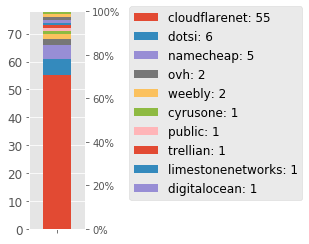

In [71]:
fig = plt.figure(figsize=(1, 4))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax2 = plt.subplot2grid((1,1), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

asn.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12).set_zorder(1)
ax2.set_xlabel("")
ax2.set_ylim(0,len(df_ips_extended.dropna()))

legend_show_top=10
labels = ['{0}: {1}'.format(i,j) for i,j in zip(asn.index, asn.values)]

ax2.legend(ax2.patches[0:legend_show_top], 
         labels[0:legend_show_top], 
           bbox_to_anchor=(5, 1.05),
           fontsize=12)
# 
plt.setp( ax2.get_xticklabels(), visible=False)


fig.show()
fig.savefig(output_figures+'ases_scatter.eps', bbox_inches='tight',format='eps', dpi=1200)

## Filtering the list of ONLINE booter related to CloudFlare

In [76]:
booters_cloudflare = df_ips_extended['booter'][df_ips_extended['as_name'].str.contains('cloudflare',flags=re.IGNORECASE)==True]
booters_cloudflare

1               boot4free.com
2                booter.ninja
3                  booter.xyz
5      connectionstresser.com
7                  ddos.tools
8                downthem.org
10          ghoststresser.com
12                  iddos.net
13             ipstresser.com
14        networkstresser.com
18          quantumbooter.net
20        quantumstresser.net
21         signalstresser.com
22                str3ssed.me
23        strong-stresser.com
24                vbooter.org
27              freebooter.co
28          critical-boot.com
29          cyberstresser.org
30                 defcon.pro
32            webstresser.org
33            cloudstress.com
34         inferno-stress.com
35                  vdos-s.co
36              easy-down.com
37          wyfi-stresser.com
38               ipbooter.com
39           kronosbooter.com
40           dankstresser.net
41                 vedbex.com
42              netstress.org
43       superiorstresser.com
44       defianceprotocol.com
45        

## 11. Collecting and Analysing ASes Behind CBSPs
Based on: Vissers T, Van Goethem T, Joosen W, Nikiforakis N. Maneuvering around clouds: Bypassing cloud-based security providers. In Proceedings of the 22nd ACM SIGSAC Conference on Computer and Communications Security (CCS). 2015 (pp. 1530-1541). (https://cloudpiercer.org/paper/CloudPiercer.pdf) (https://cloudpiercer.org)


In [88]:
df_cloudpiercer = pd.read_csv('cloudpiercer_requests.txt', names = ['booter','scanid'],delim_whitespace=True)
cloudpiercer_tocheck = df_cloudpiercer[df_cloudpiercer['booter'].isin(booters_cloudflare)]
cloudpiercer_tocheck

,booter,scanid
35,boot4free.com,C8NIXPB3H51YXHMV
41,booter.ninja,RKRI4SAFXEC6A2MM
45,booter.xyz,N5W0RGIRNZEU7G8O
65,connectionstresser.com,6XJZEP2GYBT4XA0M
68,critical-boot.com,47WDVHXS2ADXEIP1
74,cyberstresser.org,PJ82565FGGY2FPR6
112,ddos.tools,M6JJTUSKDYZIIHS5
115,defcon.pro,CZRYYAQ883G6IVUY
138,downthem.org,LTTU47FMUIJ2H2SY
175,freebooter.co,JU26Y0V0TRNV8ROK


Removing booters that were down when cloudpiercer checked!

In [92]:
cloudpiercer_tocheck=cloudpiercer_tocheck[cloudpiercer_tocheck['scanid']!='--DOWN--']

## 11.A. Defining getip_cloudpiercer_scanid()

In [93]:
%run 'functions/scrape_cloudpiercer_scanid.ipynb'

In [94]:
scrape_cloudpiercer_scanid('6HJF0I63YZWSEU0A')

,tested_domain_name,ip
0,maximumstresser.com,104.27.160.155
1,maximumstresser.com,104.27.161.155
2,maximumstresser.com,104.27.160.155
3,maximumstresser.com,104.27.161.155
4,maximumstresser.com,173.245.58.87
5,maximumstresser.com,173.245.59.197


#### DISCLAIMER: We ask the guys from CloudPiercer.org team scanned a set Booters. They provide us the scanids. Then we retrieve the IP addresses into each scanid().

In [95]:
if (os.path.exists('enrichments/cloudpiercer_all_scanids.txt')== False):
    df_all_cloudpiercer_scanid = pd.DataFrame(columns=['tested_domain_name','ip'])

    for i in cloudpiercer_tocheck['scanid'].unique():
        print(i) #DEBUG PURPOSE
        scanid = scrape_cloudpiercer_scanid(i)
        df_all_cloudpiercer_scanid=df_all_cloudpiercer_scanid.append(scanid, ignore_index=True)

    df_all_cloudpiercer_scanid.to_csv('cloudpiercer_all_scanids.txt', sep=';')
    
else:
    print("The list of Cloudpiercer scanids was already processed.")

C8NIXPB3H51YXHMV
RKRI4SAFXEC6A2MM
N5W0RGIRNZEU7G8O
6XJZEP2GYBT4XA0M
47WDVHXS2ADXEIP1
PJ82565FGGY2FPR6
M6JJTUSKDYZIIHS5
CZRYYAQ883G6IVUY
LTTU47FMUIJ2H2SY
JU26Y0V0TRNV8ROK
LEBJVEB7Q6FCYI1P
BKI80TKNO1PI0HBM
N8QG5ALEPIE6AZ6P
BIX8OBB26XZBPARW
ZIJ5B4BNSX12ZAHY
HN4RBQSHFNZB3UIF
6SVNXJRLODOYX3VC
Z3RQIZFPYKUTO6J7
78X2LW5A7C83UARL
L5E8EG7TGXF44MB7


In [123]:
df_all_cloudpiercer_scanid = pd.read_csv('cloudpiercer_all_scanids.txt', sep=';',
                                         names = ['index','tested_domain_name', 'ip'],
                                        skiprows=1,
                                        index_col='index').reset_index(drop=True)

df_all_cloudpiercer_scanid 

,tested_domain_name,ip
0,boot4free.com,104.27.182.246
1,boot4free.com,104.27.183.246
2,boot4free.com,104.27.182.246
3,boot4free.com,104.27.183.246
4,boot4free.com,173.245.58.138
5,boot4free.com,173.245.59.105
6,booter.ninja,104.24.96.147
7,booter.ninja,104.24.97.147
8,booter.ninja,104.24.96.147
9,booter.ninja,104.24.97.147


## 11.D. Creating a bulk resquest for whois.cymru.com

In [112]:
runfunction2csv(domain_whois_info, df_all_cloudpiercer_scanid['ip'], 'iptoasn_request_cloudpiercer.csv', True)

104.27.182.246;nan;nan;nan;nan;abuse@cloudflare.com,noc@cloudflare.com,rir@cloudflare.com;nan;20180223
104.27.183.246;nan;nan;nan;nan;abuse@cloudflare.com,noc@cloudflare.com,rir@cloudflare.com;nan;20180223
173.245.58.138;nan;nan;nan;nan;noc@cloudflare.com,rir@cloudflare.com,abuse@cloudflare.com;nan;20180223
173.245.59.105;nan;nan;nan;nan;noc@cloudflare.com,rir@cloudflare.com,abuse@cloudflare.com;nan;20180223
104.24.96.147;nan;nan;nan;nan;rir@cloudflare.com,abuse@cloudflare.com,noc@cloudflare.com;nan;20180223
104.24.97.147;nan;nan;nan;nan;rir@cloudflare.com,noc@cloudflare.com,abuse@cloudflare.com;nan;20180223
173.245.58.86;nan;nan;nan;nan;abuse@cloudflare.com,noc@cloudflare.com,rir@cloudflare.com;nan;20180223
173.245.59.226;nan;nan;nan;nan;rir@cloudflare.com,abuse@cloudflare.com,noc@cloudflare.com;nan;20180223
104.25.81.114;nan;nan;nan;nan;abuse@cloudflare.com,noc@cloudflare.com,rir@cloudflare.com;nan;20180223
104.25.82.25;nan;nan;nan;nan;noc@cloudflare.com,abuse@cloudflare.com,rir@clou

141.101.121.252;2012-08-10 05:03:42;nan;2012-08-10 05:50:05;nan;abuse@cloudflare.com;nan;20180223
199.193.205.20;nan;nan;nan;nan;abuse@intermedia.net,mark@intermedia.net,support@intermedia.net;nan;20180223
64.78.52.21;nan;nan;nan;nan;abuse@intermedia.net,mark@intermedia.net,support@intermedia.net;nan;20180223
64.78.52.23;nan;nan;nan;nan;support@intermedia.net,mark@intermedia.net,abuse@intermedia.net;nan;20180223
104.23.130.78;nan;nan;nan;nan;noc@cloudflare.com,abuse@cloudflare.com,rir@cloudflare.com;nan;20180223
104.23.131.47;nan;nan;nan;nan;abuse@cloudflare.com,rir@cloudflare.com,noc@cloudflare.com;nan;20180223
141.101.112.86;2012-08-10 05:03:01;nan;2015-10-09 12:51:41;nan;abuse@cloudflare.com;nan;20180223
141.101.121.237;2012-08-10 05:03:42;nan;2012-08-10 05:50:05;nan;abuse@cloudflare.com;nan;20180223
190.93.250.7;nan;nan;nan;nan;nan;nan;20180223
198.41.184.253;nan;nan;nan;nan;abuse@cloudflare.com,rir@cloudflare.com,noc@cloudflare.com;nan;20180223
162.244.197.199;nan;nan;nan;nan;mark

104.148.77.2;nan;nan;nan;nan;nan;nan;20180223
192.200.222.98;nan;nan;nan;nan;nan;nan;20180223
104.28.12.7;nan;nan;nan;nan;abuse@cloudflare.com,noc@cloudflare.com,rir@cloudflare.com;nan;20180223
104.28.13.7;nan;nan;nan;nan;abuse@cloudflare.com,noc@cloudflare.com,rir@cloudflare.com;nan;20180223
164.132.209.38;nan;nan;nan;nan;abuse@ripe.net,hostmaster@ripe.net;nan;20180223
108.162.194.72;nan;nan;nan;nan;noc@cloudflare.com,abuse@cloudflare.com,rir@cloudflare.com;nan;20180223
108.162.198.124;nan;nan;nan;nan;abuse@cloudflare.com,rir@cloudflare.com,noc@cloudflare.com;nan;20180223
199.27.134.111;nan;nan;nan;nan;abuse@cloudflare.com,rir@cloudflare.com,noc@cloudflare.com;nan;20180223
173.245.58.101;nan;nan;nan;nan;rir@cloudflare.com,abuse@cloudflare.com,noc@cloudflare.com;nan;20180223
173.245.59.139;nan;nan;nan;nan;rir@cloudflare.com,abuse@cloudflare.com,noc@cloudflare.com;nan;20180223


## 11.E. Running iptoasn() for the IPs revealed by CloudPiercer of Booters in CloudFlare

In [114]:
teamcymru_ip2asn_bulk(df_all_cloudpiercer_scanid['ip'],'iptoasn_response_cloudpiercer.csv') 

## 11.F. Reading the output of iptoasn() for the IPs revealed by CloudPiercer of Booters in CloudFlare

In [115]:
%run 'functions/datetime_converter.ipynb'
    
df_iptoasn_response_cloudpiercer = pd.read_csv('enrichments/iptoasn_response_cloudpiercer.csv',\
                             skiprows=1,\
                             delimiter="\s+\|\s",\
                             names = ['asn', 'ip', 'bgp_prefix', 'country','registry','info_date','as_name'],\
                             converters = {'info_date' : date2_converter})


df_cloudflare_booter_ips= pd.merge(df_all_cloudpiercer_scanid,
                          df_iptoasn_response_cloudpiercer,
                          how = 'left',
                          left_on = 'ip',
                          right_on = 'ip')

## 11.G. Removing IPs that resolved into a CloudFlare AS 

In [116]:
booters_cloudpiercer_without_clouflare = df_cloudflare_booter_ips[df_cloudflare_booter_ips['as_name'].str.contains('cloudflare',flags=re.IGNORECASE)==False]

## 11.H. Getting the most updated (recent date) AS related to Booter IPs

In [117]:
booter_actual_as = booters_cloudpiercer_without_clouflare\
                        .groupby('tested_domain_name')\
                        .apply(lambda t: t[t.info_date==t.info_date.max()])\
                        [['tested_domain_name','as_name']]\
                        .reset_index(drop=True).drop_duplicates()
len(booter_actual_as)

16

## 11.I. Analysing ASes Behind CloudFlare (stacked bar)

In [118]:
booter_as_now_cloudflare = booter_actual_as['as_name']\
                                        .dropna()\
                                        .str.split(' - ').str[0]\
                                        .str.split(',').str[0]\
                                        .str.split('-').str[0]\
                                        .str.split(' ').str[0]\
                                        .str.lower()\
                                        .value_counts()

# Correction for godaddy (instead of 'as') 
booter_as_now_cloudflare.index=booter_as_now_cloudflare.index.str.replace('as','godaddy',n=1)

len(booter_as_now_cloudflare)

13

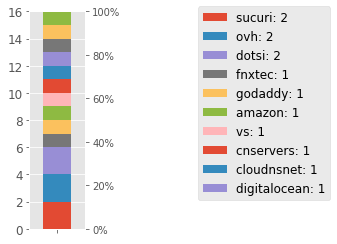

In [119]:
fig = plt.figure(figsize=(1, 4))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax2 = plt.subplot2grid((1,1), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

booter_as_now_cloudflare.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12).set_zorder(1)
ax2.set_xlabel("")
ax2.set_ylim(0,len(booter_actual_as.dropna()))

legend_show_top=10
labels = ['{0}: {1}'.format(i,j) for i,j in zip(booter_as_now_cloudflare.index, booter_as_now_cloudflare.values)]
ax2.legend(ax2.patches[0:legend_show_top], 
         labels[0:legend_show_top], 
           bbox_to_anchor=(5.5, 1.05),
           fontsize=12)

plt.setp( ax2.get_xticklabels(), visible=False)


fig.show()
fig.savefig(output_figures+'ases_incloudflare_stacked.eps', bbox_inches='tight',format='eps', dpi=1200)

## 11.J. Analysing ASes Behind CloudFlare (stacked bar & internal legend)

In [ ]:
fig = plt.figure(figsize=(3, 5))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax2 = plt.subplot2grid((1,1), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

booter_as_now_cloudflare.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12,width=0.1).set_zorder(1)
ax2.set_xlabel("")
ax2.set_ylim(0,len(booter_actual_as.dropna()))
ax2.set_xlim(-.1,0.3)
plt.setp( ax2.get_xticklabels(), visible=False)


legend_show_top=10
labels = ['{0}: {1}'.format(i,j) for i,j in zip(booter_as_now_cloudflare.index, booter_as_now_cloudflare.values)]

ax2.text(0.06, 5,'ovh',ha="left", va="center",size=12)
ax2.text(0.005, 5,'9',ha="center", va="center",size=12)

ax2.text(0.06, 11.5,'godaddy',ha="left", va="center",size=12)
ax2.text(0.005, 11.5,'5',ha="center", va="center",size=12)

ax2.text(0.06, 16.5,'dotsi',ha="left", va="center",size=12)
ax2.text(0.005, 16.5,'5',ha="center", va="center",size=12)

ax2.text(0.06, 20.5,'linode',ha="left", va="center",size=12)
ax2.text(0.005, 20.5,'3',ha="center", va="center",size=12)

ax2.text(0.06, 23.5,'namecheap',ha="left", va="center",size=12)
ax2.text(0.005, 23.5,'3',ha="center", va="center",size=12)

ax2.annotate('akamai(2)',
             (0.03,26), xycoords='data',
             xytext=(0.07,26), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('hydracom(2)',
             (0.03,28), xycoords='data',
             xytext=(0.07,29), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('cnservers(2)',
             (0.03,30), xycoords='data',
             xytext=(0.07,32), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('superservers(1)',
             (0.03,31), xycoords='data',
             xytext=(0.07,35), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('esecuredata(1)',
             (0.03,32), xycoords='data',
             xytext=(0.07,38), textcoords='data',ha='left', va='top',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)



fig.show()
fig.savefig(output_figures+'ases_incloudflare_stacked_inlegend.eps', bbox_inches='tight',format='eps', dpi=1200)

## 11.K. Combining ASes in general and ASes behind CloudFlare (stacked bar)

In [120]:
merged_asn_cloudflare = asn.add(booter_as_now_cloudflare,fill_value=0).sort_values(ascending=False)
merged_asn_cloudflare['cloudflarenet']=76-47

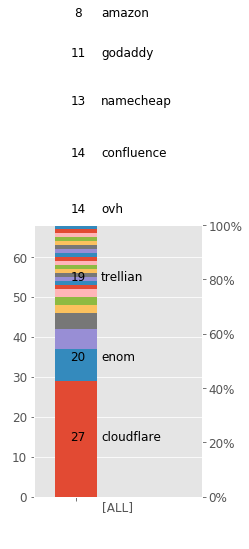

In [121]:
fig = plt.figure(figsize=(3, 5))
fig.subplots_adjust(hspace=0.5,wspace=0.3)
ax5 = plt.subplot2grid((1,1), (0,0))

ax4 = ax5.twinx()
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax4.tick_params(which='major', labelsize=12)

merged_asn_cloudflare.to_frame().T.plot(kind='bar',ax=ax5, legend=False, stacked=True, title="",fontsize=12,width=0.1).set_zorder(1)
ax5.set_xlabel("[ALL]")
ax5.set_ylim(0,merged_asn_cloudflare.sum())
ax5.set_xlim(-.1,0.3)
plt.setp( ax5.get_xticklabels(), visible=False)


legend_show_top=10
labels = ['{0}: {1}'.format(i,j) for i,j in zip(merged_asn_cloudflare.index, merged_asn_cloudflare.values)]

ax5.text(0.06, 15,'cloudflare',ha="left", va="center",size=12)
ax5.text(0.005, 15,'27',ha="center", va="center",size=12)

ax5.text(0.06, 35,'enom',ha="left", va="center",size=12)
ax5.text(0.005, 35,'20',ha="center", va="center",size=12)

ax5.text(0.06, 55,'trellian',ha="left", va="center",size=12)
ax5.text(0.005, 55,'19',ha="center", va="center",size=12)

ax5.text(0.06, 72,'ovh',ha="left", va="center",size=12)
ax5.text(0.005, 72,'14',ha="center", va="center",size=12)

ax5.text(0.06, 86,'confluence',ha="left", va="center",size=12)
ax5.text(0.005, 86,'14',ha="center", va="center",size=12)

ax5.text(0.06, 99,'namecheap',ha="left", va="center",size=12)
ax5.text(0.005, 99,'13',ha="center", va="center",size=12)

ax5.text(0.06, 111,'godaddy',ha="left", va="center",size=12)
ax5.text(0.005, 111,'11',ha="center", va="center",size=12)

ax5.text(0.06, 121,'amazon',ha="left", va="center",size=12)
ax5.text(0.005, 121,'8',ha="center", va="center",size=12)

ax5.annotate('hostinger(7)',
             (0.03,130), xycoords='data',
             xytext=(0.07,135), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax5.annotate('dotsi(6)',
             (0.03,135), xycoords='data',
             xytext=(0.07,148), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)


fig.show()
fig.savefig(output_figures+'ases_+incloudflare_stacked.eps', bbox_inches='tight',format='eps', dpi=1200)

## 11.L. Combining all ASes and explain the process (stacked bar & internal legend)

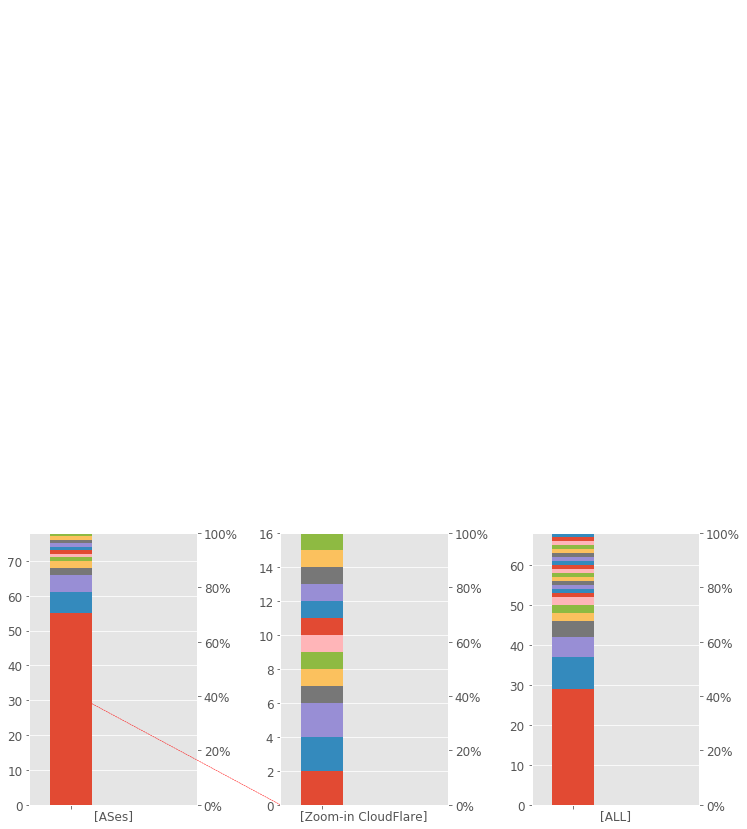

In [129]:
fig = plt.figure(figsize=(12, 5))
fig.subplots_adjust(hspace=0.5,wspace=0.5)

ax2 = plt.subplot2grid((1,3), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax1.tick_params(which='major', labelsize=12)


asn.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12,width=0.1).set_zorder(1)
ax2.set_xlabel("[ASes]")
ax2.set_ylim(0,asn.sum())
ax2.set_xlim(-.1,0.3)

plt.setp( ax2.get_xticklabels(), visible=False)

# ax2.text(0.06, 40,'cloudflare',ha="left", va="center",size=12)
# ax2.text(0.005, 40,'76',ha="center", va="center",size=12)

# ax2.text(0.06, 86,'enom',ha="left", va="center",size=12)
# ax2.text(0.005, 86,'20',ha="center", va="center",size=12)

# ax2.text(0.06, 105,'trellian',ha="left", va="center",size=12)
# ax2.text(0.005, 105,'19',ha="center", va="center",size=12)

# ax2.text(0.06, 121,'confluence',ha="left", va="center",size=12)
# ax2.text(0.005, 121,'14',ha="center", va="center",size=12)

# ax2.text(0.06, 133,'namecheap',ha="left", va="center",size=12)
# ax2.text(0.005, 133,'10',ha="center", va="center",size=12)

# ax2.annotate('amazon(7)',
#              (0.03,142), xycoords='data',
#              xytext=(0.07,145), textcoords='data',ha='left', va='center',
#              arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
#             size=12)

# ax2.annotate('teaminternet(6)',
#              (0.03,148), xycoords='data',
#              xytext=(0.07,155), textcoords='data',ha='left', va='center',
#              arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
#             size=12)

# ax2.annotate('hostinger(6)',
#              (0.03,153), xycoords='data',
#              xytext=(0.07,165), textcoords='data',ha='left', va='center',
#              arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
#             size=12)

# ax2.annotate('godaddy(6)',
#              (0.03,159), xycoords='data',
#              xytext=(0.07,175), textcoords='data',ha='left', va='center',
#              arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
#              size=12)

# ax2.annotate('ovh(5)',
#              (0.03,165), xycoords='data',
#              xytext=(0.07,185), textcoords='data',ha='left', va='center',
#              arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
#             size=12)
###################################

ax4 = plt.subplot2grid((1,3), (0,1))

ax3 = ax4.twinx()
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax3.tick_params(which='major', labelsize=12)

booter_as_now_cloudflare.to_frame().T.plot(kind='bar',ax=ax4, legend=False, stacked=True, title="",fontsize=12,width=0.1).set_zorder(1)
ax4.set_xlabel("[Zoom-in CloudFlare]")
ax4.set_ylim(0,len(booter_actual_as.dropna()))
ax4.set_xlim(-.1,0.3)
plt.setp( ax4.get_xticklabels(), visible=False)


legend_show_top=10
labels = ['{0}: {1}'.format(i,j) for i,j in zip(booter_as_now_cloudflare.index, booter_as_now_cloudflare.values)]

# ax4.text(0.06, 5,'ovh',ha="left", va="center",size=12)
# ax4.text(0.005, 5,'9',ha="center", va="center",size=12)

# ax4.text(0.06, 11.5,'godaddy',ha="left", va="center",size=12)
# ax4.text(0.005, 11.5,'5',ha="center", va="center",size=12)

# ax4.text(0.06, 16.5,'dotsi',ha="left", va="center",size=12)
# ax4.text(0.005, 16.5,'5',ha="center", va="center",size=12)

# ax4.text(0.06, 20.5,'linode',ha="left", va="center",size=12)
# ax4.text(0.005, 20.5,'3',ha="center", va="center",size=12)

# ax4.text(0.06, 23.5,'namecheap',ha="left", va="center",size=12)
# ax4.text(0.005, 23.5,'3',ha="center", va="center",size=12)

# ax4.annotate('akamai(2)',
#              (0.03,26), xycoords='data',
#              xytext=(0.07,26), textcoords='data',ha='left', va='center',
#              arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
#             size=12)

# ax4.annotate('hydracom(2)',
#              (0.03,28), xycoords='data',
#              xytext=(0.07,29), textcoords='data',ha='left', va='center',
#              arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
#             size=12)

# ax4.annotate('cnservers(2)',
#              (0.03,30), xycoords='data',
#              xytext=(0.07,32), textcoords='data',ha='left', va='center',
#              arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
#             size=12)

# ax4.annotate('superservers(1)',
#              (0.03,31), xycoords='data',
#              xytext=(0.07,35), textcoords='data',ha='left', va='center',
#              arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
#             size=12)

# ax4.annotate('esecuredata(1)',
#              (0.03,32), xycoords='data',
#              xytext=(0.07,38), textcoords='data',ha='left', va='center',
#              arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
#             size=12)

############
from matplotlib.patches import ConnectionPatch
con = ConnectionPatch(xyB=(0.05,29), coordsB="data", axesB=ax2,
                      xyA=(-0.1,0),  coordsA="data", axesA=ax4,
                      color='r',linestyle='dashed')

con2 = ConnectionPatch(xyB=(0.05,76), coordsB="data",axesB=ax2,
                       xyA=(-0.1,47), coordsA="data",axesA=ax4,
                       color='r',linestyle='dashed')

ax4.add_artist(con).set_zorder(1)
ax4.add_artist(con2).set_zorder(1)

#############
ax5 = plt.subplot2grid((1,3), (0,2))

ax4 = ax5.twinx()
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax4.tick_params(which='major', labelsize=12)

merged_asn_cloudflare.to_frame().T.plot(kind='bar',ax=ax5, legend=False, stacked=True, title="",fontsize=12,width=0.1).set_zorder(1)
ax5.set_xlabel("[ALL]")
ax5.set_ylim(0,merged_asn_cloudflare.sum())
ax5.set_xlim(-.1,0.3)
plt.setp( ax5.get_xticklabels(), visible=False)


legend_show_top=10
labels = ['{0}: {1}'.format(i,j) for i,j in zip(merged_asn_cloudflare.index, merged_asn_cloudflare.values)]

# ax5.text(0.06, 15,'cloudflare',ha="left", va="center",size=12)
# ax5.text(0.005, 15,'29',ha="center", va="center",size=12)

# ax5.text(0.06, 35,'enom',ha="left", va="center",size=12)
# ax5.text(0.005, 35,'20',ha="center", va="center",size=12)

# ax5.text(0.06, 55,'trellian',ha="left", va="center",size=12)
# ax5.text(0.005, 55,'19',ha="center", va="center",size=12)

# ax5.text(0.06, 72,'ovh',ha="left", va="center",size=12)
# ax5.text(0.005, 72,'14',ha="center", va="center",size=12)

# ax5.text(0.06, 86,'confluence',ha="left", va="center",size=12)
# ax5.text(0.005, 86,'14',ha="center", va="center",size=12)

# ax5.text(0.06, 99,'namecheap',ha="left", va="center",size=12)
# ax5.text(0.005, 99,'13',ha="center", va="center",size=12)

# ax5.text(0.06, 111,'godaddy',ha="left", va="center",size=12)
# ax5.text(0.005, 111,'11',ha="center", va="center",size=12)

# ax5.text(0.06, 121,'amazon',ha="left", va="center",size=12)
# ax5.text(0.005, 121,'8',ha="center", va="center",size=12)

# ax5.annotate('hostinger(7)',
#              (0.03,130), xycoords='data',
#              xytext=(0.07,135), textcoords='data',ha='left', va='center',
#              arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
#             size=12)

# ax5.annotate('dotsi(6)',
#              (0.03,135), xycoords='data',
#              xytext=(0.07,148), textcoords='data',ha='left', va='center',
#              arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
#             size=12)


fig.show()
fig.savefig(output_figures+'ases_+incloudflare_+merged_stacked_inlegend.eps', bbox_inches='tight',format='eps', dpi=1200)

## 11.M. Which Booters Cloudpiercer didn't find any IP address outside CloudFlare?

In [124]:
missing_booter=list(set(booters_cloudflare)-set(booter_actual_as['tested_domain_name']))
len(missing_booter),missing_booter

(39,
 ['easy-down.com',
  'rackstress.pw',
  'kronosbooter.com',
  'cloudstress.com',
  'meteor-stresser.com',
  'webstresser.org',
  'downthem.org',
  'supremestresser.net',
  'netdown.pw',
  'piratestress.pro',
  'booter.pw',
  'vedbex.com',
  'fucked-up.pw',
  'blunter.xyz',
  'nstress.com',
  'boot4free.com',
  'lightboot.org',
  'connectionstresser.com',
  'kill-lider-stresser.com',
  'quantumstress.net',
  'bearstresser.xyz',
  'quantumstresser.net',
  'ripstresser.com',
  'ipbooter.com',
  'zstresser.com',
  'stresshub.io',
  'wyfi-stresser.com',
  'ampbox.me',
  'cybertester.net',
  'booter.ninja',
  'dnsprotocol.net',
  'defianceprotocol.com',
  'netstress.org',
  'vdos-s.co',
  'booter.gq',
  'superiorstresser.com',
  'inferno-stress.com',
  'dankstresser.net',
  'webtester.pw'])

## 11.N. MANUAL test if de facto all the IPs found by CloudPiercer and resolved by TeamCymru are inside Cloudfare 

In [126]:
BOOTER_MANUAL_TEST='maximumstresser.com'

display('CloudPiercer scanid:')
display(df_cloudpiercer[df_cloudpiercer['booter']==BOOTER_MANUAL_TEST])

display(df_cloudflare_booter_ips[df_cloudflare_booter_ips['tested_domain_name']==BOOTER_MANUAL_TEST])


'CloudPiercer scanid:'

,booter,scanid
242,maximumstresser.com,6HJF0I63YZWSEU0A


,tested_domain_name,ip,asn,bgp_prefix,country,registry,info_date,as_name
